# Caso de estudio 3. Sistema no lineal de cuatro variables de estado

![Figura 3. Sistema del péndulo.](ruta/a/la/imagen.png)

Para el caso del esquema del péndulo invertido de la Fig. 3 donde el modelo es,

$$
\begin{cases}
(M + m)\ddot{\delta} + ml\dot{\phi}^2 \cos \phi - ml \ddot{\phi} \sin \phi + F \delta = u \\
\ddot{\phi} - g \sin \phi + \ddot{\delta} \cos \phi = 0
\end{cases}
\quad (4)
$$

Con las variables de estado 

$$
x = \begin{bmatrix}
\delta & \dot{\delta} & \phi & \dot{\phi}
\end{bmatrix}^T,
$$

y los valores de los coeficientes de $m=0.1$; $F=0.1$; $l=1.6$; $g=9.8$; $M=1.5$.

---

**Ítem [3]** Calcular el sistema controlador que haga evolucionar al péndulo en el equilibrio estable.

---

**Objetivo de control:** partiendo de una condición inicial nula en el desplazamiento y el ángulo en $\pi$, hacer que el carro se desplace a 10 metros evitando las oscilaciones de la masa $m$, considerando que es una grúa. Una vez que $\delta=10$ modificar a *m* a un valor 10 veces mayor y volver al origen evitando oscilaciones.

a- Considerar que sólo puede **medirse el desplazamiento $\delta$ y el ángulo $\phi$**.

b- Determinar $\Delta t$ y el tiempo de simulación necesario para el controlador en tiempo continuo.

c- Especificar el rango posible para el tiempo de muestreo para implementar el sistema en un microcontrolador.

d- Determinar el efecto de la no linealidad en la acción de control, descripta en la Fig. 1 (con dimensiones de fuerza en N), y verificar cuál es el máximo valor admisible de ésa no linealidad.


In [74]:
import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt
from pylab import *
from numpy.linalg import eig

### Linealización del modelo del péndulo invertido
 
Partimos de las ecuaciones no lineales:

$$
\begin{cases}
(M + m)\ddot{\delta} + m \cdot \text{long} \cdot \ddot{\phi}\cos(\phi) - m \cdot \text{long} \cdot \dot{\phi}^2\sin(\phi) + F\dot{\delta} = u \\
\text{long} \cdot \ddot{\phi} - g \sin(\phi) + \ddot{\delta} \cos(\phi) = 0
\end{cases}
$$

Nuestro objetivo es obtener un modelo lineal de la forma:

$$
\dot{x} = A x + B u, \quad \text{con } x = [\delta, \dot{\delta}, \phi, \dot{\phi}]^T
$$

Donde los parametros son:
- M: masa del carro (kg)
- m: masa del péndulo (kg)
- long: longitud del péndulo (m)
- F: coeficiente de fricción del carro (N·s/m)
- g: aceleración de la gravedad (m/s²)
- u: fuerza de control aplicada al carro (N)



#### Punto de equilibrio

El equilibrio se alcanza cuando:

$$
\delta = 0, \quad \dot{\delta} = 0, \quad \phi = \pi, \quad \dot{\phi} = 0
$$

Definimos el ángulo relativo al equilibrio (cambio de variable):

$$
\tilde{\phi} = \phi - \pi
$$

Usamos desarrollos de Taylor de primer orden:

- $\cos(\phi) = \cos(\tilde{\phi}+\pi) \approx -1$
- $\sin(\phi) = \sin(\tilde{\phi}+\pi) \approx -\tilde{\phi}$



Dado que $\dot{\phi} \approx 0$ cuando está alrededor del equilibrio estable, consideramos:


$$\dot{\phi}^2 \cdot \sin(\phi) \approx 0 $$
---

#### Reescribimos las ecuaciones




\begin{aligned}
(M + m)\ddot{\delta} - m l \ddot{\phi} + F \dot{\delta} &= u  \quad \text{(1')} \\
l \ddot{\phi} + g \tilde{\phi} - \ddot{\delta} &= 0 \quad \text{(2')}
\end{aligned}



 

---

#### Hacmoes sustitución entre ecuaciones
De la segunda ecuación:

$$
\ddot{\phi} = \frac{\ddot{\delta} - g \tilde{\phi}}{l}
$$

Sustituyendo en la primera:

$$
(M + m)\ddot{\delta} - m\left(\ddot{\delta} - g \tilde{\phi}\right) + F \dot{\delta} = u
$$

$$
M \ddot{\delta} + m g \tilde{\phi} + F \dot{\delta} = u
$$

Despejando:

$$
\boxed{\ddot{\delta} = \frac{1}{M} \left( u - m g \tilde{\phi} - F \dot{\delta} \right)}
$$

Y sustituyendo de nuevo en la primera ecuación para obtener $\ddot{\phi}$:

$$
\boxed{\ddot{\phi} = \frac{1}{lM} u - \frac{F}{lM} \dot{\delta} - \frac{g(M + m)}{lM} \tilde{\phi}}
$$
---
Asumiendo $\tilde{\phi} \approx \phi$ (mismo símbolo para simplificar), el sistema es:


\begin{aligned}
\dot{x}_1 &= x_2 \\
\dot{x}_2 &= -\frac{F}{M} x_2 - \frac{m g}{M} x_3 + \frac{1}{M} u \\
\dot{x}_3 &= x_4 \\
\dot{x}_4 &= -\frac{F}{l M} x_2 - \frac{g (M + m)}{l M} x_3 + \frac{1}{l M} u
\end{aligned}


---

### Forma matricial: $\dot{x} = A x + B u$

**Matriz $A$:**

$$
A = \begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & -\frac{F}{M} & -\frac{m g}{M} & 0 \\
0 & 0 & 0 & 1 \\
0 & -\frac{F}{l M} & -\frac{g (M + m)}{l M} & 0
\end{bmatrix}
$$

**Matriz $B$:**

$$
B = \begin{bmatrix}
0 \\
\frac{1}{M} \\
0 \\
\frac{1}{l M}
\end{bmatrix}
$$
---


In [75]:
# Parámetros del sistema
m = 0.1     # masa del péndulo [kg]
M = 1.5     # masa del carro [kg]
long = 1.6  # longitud del péndulo [m]
g = 9.8     # gravedad [m/s^2]
F = 0.1     # coeficiente de fricción del carro [N·s/m]

In [76]:
A = np.array([
    [0,                     1,                  0,                            0],
    [0,                -F / M,         -m * g / M,                            0],
    [0,                     0,                  0,                            1],
    [0,       -F / (long * M),  -g * (M + m) / (long * M),                    0]
])
 
B = np.array([
    [0],
    [1 / M],
    [0],
    [1 / (long * M)]
])


# C para el integrador
C = np.array([[1, 0, 0, 0]])

# C_obs para las mediciones que recibe el obs. salidas medidas (posición del carro y ángulo del péndulo)
C_obs = np.array([
    [1, 0, 0, 0],   # mide delta (posición del carro)
    [0, 0, 1, 0]    # mide phi (ángulo del péndulo)
])




## Matriz ampliada para el sistema con integrador

 

El sistema original de 4 estados se amplía con un integrador del error de posición. Las matrices extendidas son:

$$
A_{\text{aug}} = \begin{bmatrix}
A & 0 \\
-C & 0
\end{bmatrix}, \quad
B_{\text{aug}} = \begin{bmatrix}
B \\
0
\end{bmatrix}
$$

donde $ C $ selecciona el estado a integrar (este caso, la posición).

In [77]:
# Ampliar matrices para el sistema con integrador
A_aug = np.block([
    [A, np.zeros((4, 1))],
    [-C, np.zeros((1, 1))]
])

B_aug = np.vstack((B, [[0]]))

## Diseño del controlador LQR

Queremos encontrar la **matriz de ganancia**:

$$
u(t) = -Kx(t) - K_i z(t)
$$

donde $ x(t) $ es el estado del sistema, y $ z(t) $ es un estado integrador del error (por ejemplo, error de posición).


### Ecuación de Riccati

La solución tradicional al problema LQR se basa en encontrar una matriz simétrica positiva definida $ P $ que resuelva la ecuación algebraica de Riccati:

$$
A^T P + P A - P B R^{-1} B^T P + Q = 0
$$

Una vez hallada $ P$, la ganancia del controlador es:

$$
K = R^{-1} B^T P
$$

In [78]:
from scipy.linalg import solve_continuous_are

# Pesos del LQR
Q = np.diag([100, 1, 500, 10, 1000])  # peso alto para φ y para el integrador
R = np.array([[0.1]])

# Resolver la ecuación de Riccati
P = solve_continuous_are(A_aug, B_aug, Q, R)

# Ganancia LQR
K_aug = np.linalg.inv(R) @ B_aug.T @ P

K = K_aug[:, :4]  # realimentación de estados
Ki = K_aug[:, 4]  # ganancia del integrador


### Cálculo de la Ganancia LQR mediante el Hamiltoniano

El **Hamiltoniano** del sistema ampliado es una matriz de dimensión $ 2n \times 2n $, donde $ n $ es el número de estados extendidos.

$$
H =
\begin{bmatrix}
A_{\text{aug}} & -B_{\text{aug}} R^{-1} B_{\text{aug}}^T \\
-Q & -A_{\text{aug}}^T
\end{bmatrix}
$$

In [79]:

# Construcción del Hamiltoniano para el cálculo del controlador

# Hamiltoniano H = [A -BR^-1B^T ; -Q -A^T]
H_top = np.block([
    [A_aug, -B_aug @ inv(R) @ B_aug.T]
])
H_bottom = np.block([
    [-Q, -A_aug.T]
])
H = np.block([
    [H_top],
    [H_bottom]
])


### Cálculo de autovalores y autovectores

Se hallan los **autovalores y autovectores** de \( H \), y se seleccionan únicamente aquellos cuya **parte real es negativa**, para asegurar estabilidad:

Luego se separan en dos bloques verticales:

$$
V = 
\begin{bmatrix}
X_1 \\
X_2
\end{bmatrix}
\quad \text{con} \quad X_1, X_2 \in \mathbb{C}^{n \times n}
$$

In [80]:

# Eigenvalores y vectores propios
D, V = eig(H)

# Seleccionar autovectores con parte real negativa
n = A_aug.shape[0]
MX1X2 = np.zeros((2 * n, n), dtype=complex)
jj = 0
for ii in range(2 * n):
    if np.real(D[ii]) < 0:
        MX1X2[:, jj] = V[:, ii]
        jj += 1
        if jj >= n:
            break

# Separar bloques
MX1 = MX1X2[:n, :]
MX2 = MX1X2[n:, :]



### Cálculo de la matriz $P$

Usamos la relación:

$$
P = \Re\left\{ X_2 X_1^{-1} \right\}
$$

Esto nos da la solución $ P $ de la ecuación de Riccati.

In [81]:
# Calcular P
P_ham = np.real(MX2 @ inv(MX1))



### Cálculo de la ganancia LQR

Finalmente, la **ganancia óptima** del controlador se obtiene como:

$$
K_{\text{aug}} = R^{-1} B_{\text{aug}}^T P
$$

Esta matriz se puede dividir en dos partes:

- $ K $: la realimentación de los estados del sistema original.
- $ K_i $: la ganancia del integrador.

$$
K = K_{\text{aug}}[:, 0:4], \quad K_i = K_{\text{aug}}[:, 4]
$$

In [82]:
# Ganancia LQR desde el Hamiltoniano
K_aug_ham = inv(R) @ B_aug.T @ P_ham
K_ham = K_aug_ham[:, :4]
Ki_ham = K_aug_ham[:, 4]

K_ham, Ki_ham

(array([[ 91.60226558,  36.8548753 ,  26.00612686, -28.24155097]]),
 array([-100.]))

In [83]:
# Comparamos los resultados de los dos métodos de cálculo de ganancias

print("DEBERIAN DAR LO MISMO")
print("Ganancias con la libreria")
print(f"K = {K}")
print(f"Ki = {Ki}")
print("\nGanancias con el método Hamiltoniano:")
print(f"K_ham = {K_ham}")
print(f"Ki_ham = {Ki_ham}")

# Calculamos la diferencia entre ambos métodos
K_diff = np.linalg.norm(K - K_ham)
Ki_diff = np.linalg.norm(Ki - Ki_ham)

print("\nDiferencias:")
print(f"||K - K_ham|| = {K_diff}")
print(f"||Ki - Ki_ham|| = {Ki_diff}")



DEBERIAN DAR LO MISMO
Ganancias con la libreria
K = [[ 91.60226558  36.8548753   26.00612686 -28.24155097]]
Ki = [-100.]

Ganancias con el método Hamiltoniano:
K_ham = [[ 91.60226558  36.8548753   26.00612686 -28.24155097]]
Ki_ham = [-100.]

Diferencias:
||K - K_ham|| = 1.9998591042993866e-12
||Ki - Ki_ham|| = 1.5347723092418164e-12


## Observador

In [84]:
 
# Elegimos polos del observador más rápidos que los del sistema
# (por ejemplo, 5-10x más rápidos que los del sistema)
from scipy.signal import place_poles

# Elegir polos deseados del observador
observer_poles = [-10, -11, -12, -13]

# Calcular ganancia del observador (sólo para los 4 estados, no el integrador)
L = place_poles(A.T, C_obs.T, observer_poles).gain_matrix.T


## Simulacion


In [85]:
# Referencia
delta_ref_1 = 10
delta_ref_2 = 0

# Tiempo de simulación
dt = 0.005
T_total = 20
steps = int(T_total / dt)

# Estados iniciales
x = np.zeros(4)
x_hat = np.zeros(4)
z = 0

# para graficar
u = 0.0
time = []
delta = []
phi = []
u_values = []
delta_ref_traj = []

In [86]:
# Simulación
for i in range(steps):
    t = i * dt
    # Cambio de referencia y masa
    if t < 10:
        delta_ref = delta_ref_1 
    else:
        delta_ref = delta_ref_2
        A = np.array([
            [0,                     1,                  0,                            0],
            [0,                -F / M,       -m*10* g / M,                            0],
            [0,                     0,                  0,                            1],
            [0,       -F / (long * M),  -g * (M + m*10) / (long * M),                 0]
        ])
        

    # Salida medida
    y = C_obs @ x

    # Observador (modelo con m actual)
    x_hat_dot = A @ x_hat + B.flatten() * u - L @ (C_obs @ x_hat - y)
    x_hat += x_hat_dot * dt

    # Integrador del error
    z_dot = delta_ref - y[0]
    z += z_dot * dt

    # Control
    u = -K @ x_hat - Ki * z

    # Simulación del sistema real (con m real en cada tramo)
    x_dot = A @ x + B.flatten() * u
    x += x_dot * dt

    # Guardar
    time.append(t)
    delta.append(x[0])
    phi.append(x[2])
    u_values.append(u.item())
    delta_ref_traj.append(delta_ref)

## Graficar

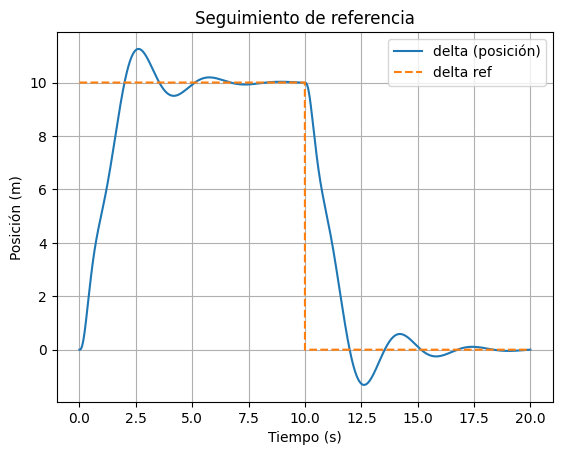

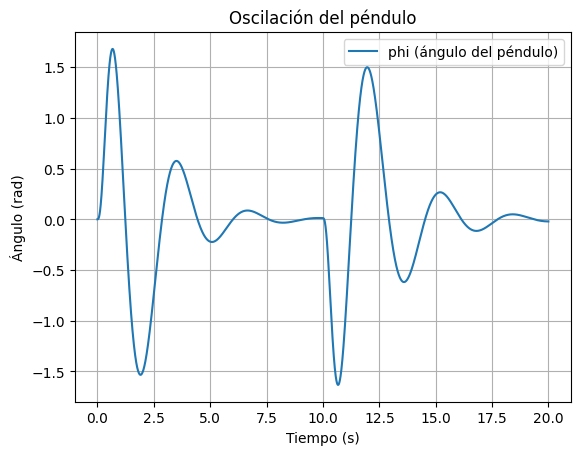

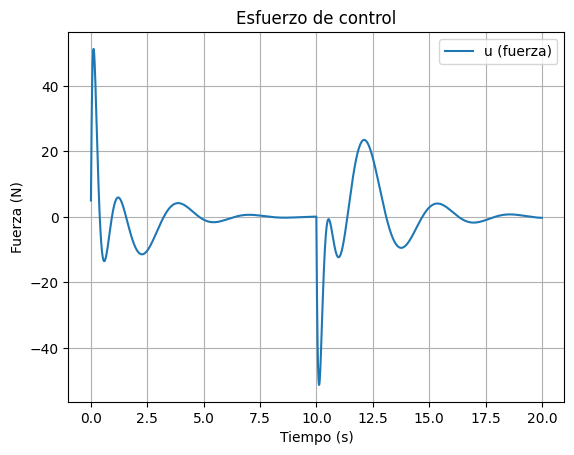

In [87]:
# Graficar resultados
plt.figure()
plt.plot(time, delta, label='delta (posición)')
plt.plot(time, delta_ref_traj, '--', label='delta ref')
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición (m)')
plt.title('Seguimiento de referencia')
plt.legend()
plt.grid()

plt.figure()
plt.plot(time, phi, label='phi (ángulo del péndulo)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Ángulo (rad)')
plt.title('Oscilación del péndulo')
plt.legend()
plt.grid()

plt.figure()
plt.plot(time, u_values, label='u (fuerza)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Fuerza (N)')
plt.title('Esfuerzo de control')
plt.legend()
plt.grid()

plt.show()